In [4]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/eda.csv')

# Client Profile: Larry Sanders

 **Larry Sanders** is a **Buyer**.  

He is looking for a very specific combination of features:

- **Waterfront** property  
- **Limited budget** (affordable compared to typical waterfront homes)  
- **Nice & isolated** neighborhood  
- **Central location** (not too far from the city)  
- **Without kids** (he has children himself, but prefers neighborhoods with fewer children due to health concerns)  

---

### In other words, Larry is searching for the classic *Eierlegende Wollmilchsau*:  

- A **waterfront house** that is not too expensive  
- In a **nice neighborhood**, ideally with renovated homes in “better” quarters  
- **Central but isolated** (can be approximated by zipcode and neighborhood features like lot sizes)  
- A **bigger house** (sufficient space for his kids)  
- Surrounded by **smaller neighboring homes** (fewer large family houses → fewer kids nearby)  


---


### Mapping Larry's Requirements to Dataset Features

- **Waterfront** → `waterfront`  
- **Budget** → `price`  
- **Central** → `zipcode`, `latitude`, `longitude`  
- **Isolated** → `sqft_lot`, `sqft_lot15`  
- **Without kids** → proxy via smaller `sqft_living15` + fewer `bedrooms` in surrounding homes  
- **Nice neighborhood** → proxy via `yr_renovated`, `condition_rating`, `grade`  and in sussounding homes


# Hypothesizes

**1 – Waterfront premium**

- **H₀:** Waterfront homes have the same average price as non-waterfront homes.  
- **H₁:** Waterfront homes are more expensive than non-waterfront homes.  

**2 – Renovation value**

- **H₀:** Renovated homes do not differ in price compared to non-renovated homes of similar size.  
- **H₁:** Renovated homes are more expensive than non-renovated homes of similar size.  

**3 – Kids proxy (family-oriented neighborhoods)**

- **H₀:** House/neighborhood size is unrelated to family orientation (number of kids).  
- **H₁:** Larger homes (more bedrooms, higher `sqft_living15`) are proxies for more family-oriented neighborhoods (more kids), while smaller homes in areas with large `sqft_lot15` suggest more isolated, less kid-heavy neighborhoods.  


# Data Exploration and Cleaning

## First Exploration steps

### Columns

In [5]:
df.columns

Index(['house_id', 'sale_id', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view_rating', 'condition_rating',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'latitude', 'longitude', 'sqft_living15', 'sqft_lot15',
       'sale_date', 'price'],
      dtype='object')

### Datatypes

In [6]:
df.dtypes

house_id              int64
sale_id               int64
bedrooms            float64
bathrooms           float64
sqft_living         float64
sqft_lot            float64
floors              float64
waterfront          float64
view_rating         float64
condition_rating      int64
grade                 int64
sqft_above          float64
sqft_basement       float64
yr_built              int64
yr_renovated        float64
zipcode               int64
latitude            float64
longitude           float64
sqft_living15       float64
sqft_lot15          float64
sale_date            object
price               float64
dtype: object

### Overview 

In [7]:
df.describe()

,house_id,sale_id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view_rating,condition_rating,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,latitude,longitude,sqft_living15,sqft_lot15,price
count,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19206.000000,21534.000000,21597.000000,...,21597.000000,21145.000000,21597.000000,17749.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,2.159700e+04
mean,4.580474e+09,10799.000000,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007602,0.233863,3.409825,...,1788.596842,291.857224,1970.999676,836.650516,98077.951845,47.560093,-122.213983,1986.620318,12758.283512,5.402966e+05
std,2.876736e+09,6234.661218,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086858,0.765686,0.650546,...,827.759761,442.490863,29.375234,4000.110554,53.513072,0.138552,0.140724,685.230472,27274.441950,3.673681e+05
min,1.000102e+06,1.000000,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,...,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,7.800000e+04
25%,2.123049e+09,5400.000000,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,...,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,3.220000e+05
50%,3.904930e+09,10799.000000,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,...,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,4.500000e+05
75%,7.308900e+09,16198.000000,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,...,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,6.450000e+05
max,9.900000e+09,21597.000000,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,...,9410.000000,4820.000000,2015.000000,20150.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,7.700000e+06


### Duplicates

In [8]:
df.duplicated().sum()


np.int64(0)

### NaN Values

In [9]:
df.isna().sum()

house_id               0
sale_id                0
bedrooms               0
bathrooms              0
sqft_living            0
sqft_lot               0
floors                 0
waterfront          2391
view_rating           63
condition_rating       0
grade                  0
sqft_above             0
sqft_basement        452
yr_built               0
yr_renovated        3848
zipcode                0
latitude               0
longitude              0
sqft_living15          0
sqft_lot15             0
sale_date              0
price                  0
dtype: int64

##### Handling NaN Values

- **Waterfront**  
  Probably a measuring or capturing error.  
  → We assume that no value means the house is **not at the waterfront**.  

- **View Rating**  
  Likely a capturing error, since only a few entries are missing.  
  → We could **safely drop** these rows.  
  (Optional: construct a proxy view rating based on proximity and number of floors).  

- **Sqft Basement**  
  Probably a capturing error.  
  → Either means:  
  - The house has **no basement**.
  - The basement was forgotten, in this case the size of the basement can be infered by : **sqft_basement = sqft_living - sqft_above**  

- **Year Renovated**  
  If a house has no value here, it probably has **never been renovated**.  
  → Keep the year values as-is, but add a new column:  
  - `is_renovated = 1` if `yr_renovated` exists  
  - `is_renovated = 0` otherwise  
  → Sanity check: compare `yr_built` with `yr_renovated` (renovation should always be later).  


## Data Cleaning

### SQFT Basement

1.) Check for faulty values in sqft_living or sqft_above to avoid negative basement sizes

In [10]:
(df['sqft_living'] < df['sqft_above'] ).sum()

np.int64(0)

2.) Create a mask only if the basement value is NaN

In [11]:
mask = df['sqft_basement'].isna()

mask

0        False
1        False
2        False
3        False
4        False
         ...  
21592    False
21593    False
21594    False
21595    False
21596    False
Name: sqft_basement, Length: 21597, dtype: bool

3.) Set all NaN basement values to : **sqft_basement = sqft_living - sqft_above** 

In [12]:
df.loc[mask,'sqft_basement'] = (df['sqft_living'] - df['sqft_above'])[mask]

In [13]:
df.isna().sum()

house_id               0
sale_id                0
bedrooms               0
bathrooms              0
sqft_living            0
sqft_lot               0
floors                 0
waterfront          2391
view_rating           63
condition_rating       0
grade                  0
sqft_above             0
sqft_basement          0
yr_built               0
yr_renovated        3848
zipcode                0
latitude               0
longitude              0
sqft_living15          0
sqft_lot15             0
sale_date              0
price                  0
dtype: int64

#### Waterfront



The `waterfront` feature has a large number of missing values. One option would be to simply assume that missing values mean not waterfront, but before making such an imputation, we explore the data further.

**Assumption**: Houses located at the `waterfront` are expected to have a higher `view_rating` compared to those that are not at the waterfront.

**Approach**: Check correlations.



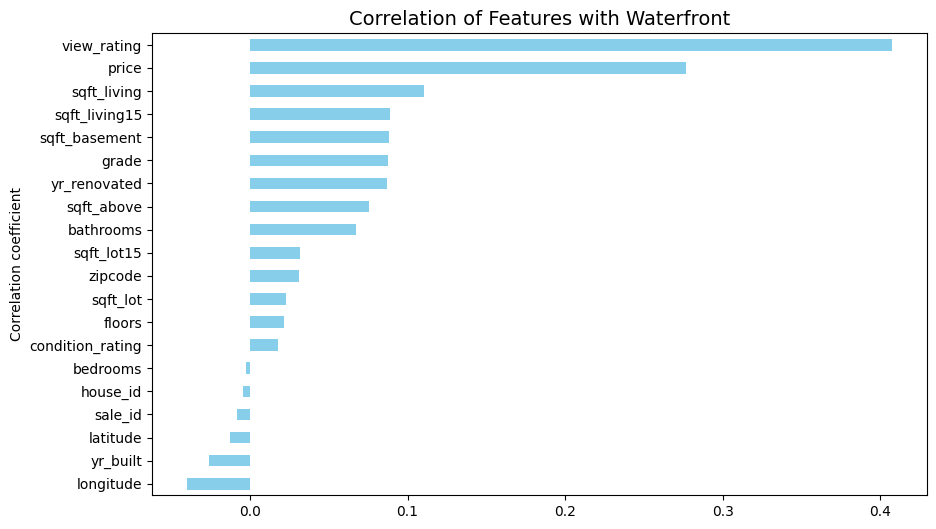

,Feature,Correlation with Waterfront
0,view_rating,0.407156
1,price,0.276387
2,sqft_living,0.110233
3,sqft_living15,0.088854
4,sqft_basement,0.087940
5,grade,0.087365
6,yr_renovated,0.087226
7,sqft_above,0.075441
8,bathrooms,0.067296
9,sqft_lot15,0.031924


In [79]:
water_fron_corr = df.corr(numeric_only=True)['waterfront'].sort_values(ascending=True)

plt.figure(figsize=(10,6))
water_fron_corr.drop('waterfront').plot(kind='barh', color='skyblue')
plt.title("Correlation of Features with Waterfront", fontsize=14)
plt.ylabel("Correlation coefficient")
plt.show()



corr_table = water_fron_corr.drop('waterfront') \
                            .sort_values(ascending=False) \
                            .reset_index()

corr_table.columns = ['Feature', 'Correlation with Waterfront']


corr_table

##### Findings

**Observation**: We can observe that our assumption is valid and the `waterfront` feature has its highest correlation with the `view_rating`.  

**Hypothesis**: We can simply impute missing `waterfront` values by setting `waterfront` = 1 if  `view_rating` is high and vice versa.


For a better grip of the spatial distribution and see wheter our hypothesis is true we first plot an interactive Folium map, coloring them according to their waterfront status and view_rating:

**Yellow** → Houses explicitly marked as waterfront (1).

**Grey** → Houses explicitly marked as not waterfront (0).

**Green** → Houses with missing waterfront but a high view_rating (≥ 3), indicating they are likely waterfront.

**Blue** → Houses with missing waterfront and a low view_rating (< 3), suggesting not waterfront.

**Red** → Houses with both waterfront and view_rating missing.

This visualization allows us to see whether the missing values follow the same spatial pattern as known waterfront properties.


In [ ]:
import folium
import pandas as pd

df_water = df.copy()

# Center map roughly on King County
m = folium.Map(location=[47.55, -122.2], zoom_start=10, tiles="OpenStreetMap")

for _, row in df_water.iterrows():
    # Case 1: actual waterfront houses
    if row["waterfront"] == 1:
        color = "yellow"
    
    # Case 2: waterfront is missing
    elif pd.isna(row["waterfront"]):
        if pd.isna(row["view_rating"]):
            color = "red"      # missing view_rating
        elif row["view_rating"] >= 3.0:
            color = "green"    # likely waterfront
        else:
            color = "blue"     # likely not waterfront
    
    # Case 3: actual non-waterfront houses
    else:
        color = "grey"
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color=color,
        fill=True,
        fill_opacity=0.6,
        popup=f"View: {row['view_rating']}, Waterfront: {row['waterfront']}"
    ).add_to(m)

# Add a legend (custom HTML overlay)
legend_html = """
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 200px; height: 140px; 
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white; padding: 10px;">
<b>Legend</b><br>
<span style="color:yellow;">●</span> Waterfront<br>
<span style="color:grey;">●</span> Not waterfront<br>
<span style="color:green;">●</span> Missing WF, high view (≥3)<br>
<span style="color:blue;">●</span> Missing WF, low view (<3)<br>
<span style="color:red;">●</span> Missing both WF & view<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Save map
m.save("data/maps/king_county_houses_wf_nan.html")

m


##### Findings II

**Observations:**  
- Only houses located **directly at the sea or connected waterways** are marked as `waterfront`. Houses at **lakes or rivers** in the inland are **not** labeled as waterfront.  
- Many houses with a **missing `waterfront` status** but located near the sea show **high `view_rating` scores**, suggesting they are likely waterfront properties.  
- A subset of houses has **both `waterfront` and `view_rating` missing**, making it impossible to infer their status from the available data.  

**Approach:**  
Since `view_rating` is strongly correlated with `waterfront` (≈ 0.41), we use it as the primary proxy to impute missing values. The assumption is:  
- If `view_rating` is **high (≈ 4)** → the house is likely waterfront.  
- Otherwise → the house is not waterfront.  

This heuristic is supported by the fact that **83% of actual waterfront homes** have a `view_rating` of 4, while only **0.87% of non-waterfront homes** reach this level.  

**Validation:**  
To check for exceptions, we analyzed waterfront houses with **`view_rating < 4`**, grouped by `zipcode`. The results show that in a few zipcodes, waterfront properties are rated significantly lower:  

| Zipcode | Count | Min | Mean | Median | Max |
|---------|-------|-----|------|--------|-----|
| 98004   | 1     | 2.0 | 2.00 | 2.0    | 2.0 |
| 98040   | 2     | 3.0 | 3.00 | 3.0    | 3.0 |
| 98052   | 1     | 2.0 | 2.00 | 2.0    | 2.0 |
| 98070   | 11    | 1.0 | 2.55 | 3.0    | 3.0 |
| 98075   | 2     | 3.0 | 3.00 | 3.0    | 3.0 |
| 98105   | 2     | 2.0 | 2.50 | 2.5    | 3.0 |
| 98166   | 2     | 2.0 | 2.50 | 2.5    | 3.0 |
| 98199   | 1     | 3.0 | 3.00 | 3.0    | 3.0 |

This shows that some waterfront homes—especially in zipcodes **98070, 98105, and 98166**—can have median view ratings as low as **2.5–3.0**, rather than the expected 4.  

**Conclusion:**  
It is therefore **reasonable to impute missing `waterfront` values via `view_rating`**, with the caveat that this approach may slightly **overestimate** waterfront status. While most waterfront homes indeed have the maximum view rating, a small minority do not. For exploratory analysis, this trade-off is acceptable, but in a predictive model, a more nuanced rule (e.g., zipcode-specific thresholds) might be preferable.  



In [95]:
df_imputed = df.copy()

mask = df_imputed['waterfront'].isna()

df_imputed.loc[mask & df_imputed['view_rating'].notna(), 'waterfront'] = (
    (df_imputed.loc[mask & df_imputed['view_rating'].notna(), 'view_rating'] == 4).astype(int)
)


'''
@ToDo:

handle last missing entries in waterfron wher no viewarating and no waterfrotn status combine cleaned ds 
'''


df_imputed['waterfront'].isna().sum()

np.int64(6)

In [63]:
# count of waterfront houses by view rating
counts = df.query("waterfront == 1")['view_rating'].value_counts().sort_index()

# total number of waterfront houses
total = counts.sum()

# percentage with 
view = 4.0
view4 = counts.get(view, 0)
perc_view4 = view4 / total * 100

print(f"Waterfront houses with view={view}:", view4)
print("Total waterfront houses:", total)
print(f"Percentage: {perc_view4:.2f}%")


Waterfront houses with view=4.0: 123
Total waterfront houses: 145
Percentage: 84.83%


### View

Research any correlations between view and any other value


In [44]:
pd.unique(df['view_rating'])

array([ 0., nan,  3.,  4.,  2.,  1.])

In [16]:
df.corr(numeric_only=True)['view_rating'].sort_values(ascending=False)


view_rating         1.000000
waterfront          0.407156
price               0.395734
sqft_living         0.282532
sqft_living15       0.279561
sqft_basement       0.274887
grade               0.249727
bathrooms           0.186451
sqft_above          0.166299
yr_renovated        0.100795
zipcode             0.085277
bedrooms            0.078523
sqft_lot            0.075298
sqft_lot15          0.073332
condition_rating    0.045735
floors              0.028436
house_id            0.011592
latitude            0.006141
sale_id            -0.013607
yr_built           -0.054564
longitude          -0.077894
Name: view_rating, dtype: float64

There is a very high correlation between the waterfront and the price. So more expensive houses at the water seem to have better views.
We fill these 'view' NaN's with the median for waterfront houses and non waterfront houses respectively based on, taking the price into account. 

In [17]:
df_view = df.copy()


df_view['view_rating'] = df_view.groupby(['waterfront','zipcode'])['view_rating'].transform(lambda x : x.fillna(x.median()))


df_view['view_rating'].isna().sum()

np.int64(2391)